In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SERVS and SWIRE) I will split the XID+ run into two different runs. Here we use the SERVS depth.

In [3]:
Sel_func=pymoc.MOC()
# Sel_func.read('../data/CDFS-SWIRE/holes_CDFS-SWIRE_irac1_O16_MOC.fits')
Sel_func.read('../../dmu4/dmu4_sm_CDFS-SWIRE/data/holes_CDFS-SWIRE_irac1_O16_MOC.fits') # Update masterlist

## Read in XID+MIPS catalogue

In [4]:
# XID_MIPS=Table.read('../data/CDFS-SWIRE/MIPS/dmu26_XID+MIPS_CDFS-SWIRE_cat_20170901.fits')
XID_MIPS=Table.read('../dmu26_XID+MIPS_CDFS-SWIRE/data/dmu26_XID+MIPS_CDFS-SWIRE_cat_20201205.fits') # Update masterlist

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J033650.824-295620.783,54.211766390022845,-29.9391064859918,272.50247,540.70447,86.236374,-0.003483794,5.029496e-06,1.0027044,1124.0,0.0,False
HELP_J033655.442-295449.596,54.23101021455793,-29.91377659143576,236.55391,506.73215,68.16577,-0.0006361296,5.0581343e-06,0.9994119,1476.0,0.0,False
HELP_J033616.314-295548.181,54.067976200022855,-29.9300503059918,301.9198,318.07288,286.00903,-0.004160782,5.0500876e-06,nan,1700.0,0.0,False
HELP_J033601.094-295546.425,54.00455690002285,-29.929562435991798,81.58568,95.428375,67.528366,0.0016651336,4.938521e-06,nan,1122.0,0.0,False
HELP_J033608.786-295409.821,54.03660934002285,-29.9027279559918,6.9124126,15.632443,2.0185032,-0.0052455342,5.063621e-06,nan,2000.0,0.0,True
HELP_J033606.888-295518.496,54.028701300022846,-29.9218044959918,36.028355,50.140163,21.682087,-0.0052455342,5.063621e-06,nan,719.0,0.0,False
HELP_J033610.856-295506.940,54.04523478002285,-29.918594405991797,250.45511,263.87708,237.46614,-0.0052455342,5.063621e-06,nan,1863.0,0.0,False
HELP_J033607.350-295516.790,54.030623590022856,-29.9213304359918,184.89633,199.12378,170.45247,-0.0052455342,5.063621e-06,nan,1419.0,0.0,False


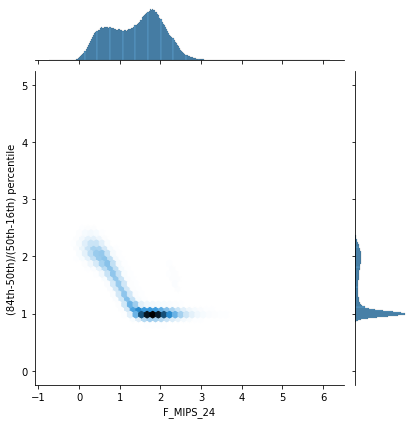

In [6]:
import seaborn as sns
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use], kind='hex')

The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [7]:
good=XID_MIPS['F_MIPS_24']>20

In [8]:
good.sum()

283406

## Read in Maps

In [12]:

# im100fits='../data/CDFS-SWIRE/PACS/CDFS-SWIRE_PACS100_20160413_img_wgls.fits'#PACS 100 map
# nim100fits='../data/CDFS-SWIRE/PACS/CDFS-SWIRE_PACS100_20160413_img_noise.fits'#PACS 100 noise map
# im160fits='../data/CDFS-SWIRE/PACS/CDFS-SWIRE_PACS160_20160413_img_wgls.fits'#PACS 160 map
# nim160fits='../data/CDFS-SWIRE/PACS/CDFS-SWIRE_PACS160_20160413_img_noise.fits'#PACS 100 noise map
# #output folder
# output_folder='./'


im100fits='../../dmu18/dmu18_CDFS-SWIRE/data/CDFS-SWIRE_PACS100_20160413_img_wgls.fits'#PACS 100 map
nim100fits='../../dmu18/dmu18_CDFS-SWIRE/data/CDFS-SWIRE_PACS100_20160413_img_noise.fits'#PACS 100 noise map
im160fits='../../dmu18/dmu18_CDFS-SWIRE/data/CDFS-SWIRE_PACS160_20160413_img_wgls.fits'#PACS 160 map
nim160fits='../../dmu18/dmu18_CDFS-SWIRE/data/CDFS-SWIRE_PACS160_20160413_img_noise.fits'#PACS 100 noise map
#output folder
output_folder='./data/'


In [13]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=np.power(hdulist[0].data,0.5)#sqrt as variance map
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist[0].header

im160=hdulist[0].data #convert to mJy
w_160 = wcs.WCS(hdulist[0].header)
pixsize160=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim160fits)
nim160=np.power(hdulist[0].data,0.5)#sqrt as variance map
hdulist.close()


## Read in PSF

In [15]:
pacs100_psf=fits.open('../../dmu18/dmu18_CDFS-SWIRE/data/dmu18_PACS_100_PSF_CDFS-SWIRE_20171002.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_CDFS-SWIRE/data/dmu18_PACS_160_PSF_CDFS-SWIRE_20171002.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




In [16]:
print(pind100)

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.        ]


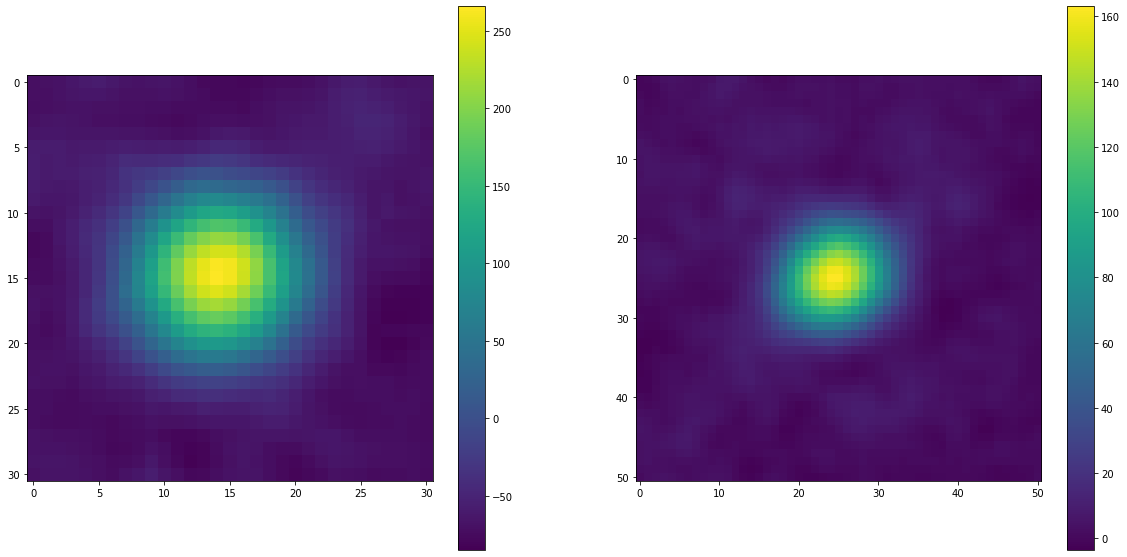

In [17]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [18]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_CDFS-SWIRE_cat_20201208.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Sel_func)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_CDFS-SWIRE_cat_20201208.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


In [19]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [16]:
# import pickle
# #from moc, get healpix pixels at a given order
# from xidplus import moc_routines
# order=11
# tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
# order_large=6
# tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
# print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
# output_folder='./'
# outfile=output_folder+'Master_prior.pkl'
# with open(outfile, 'wb') as f:
#     pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
# outfile=output_folder+'Tiles.pkl'
# with open(outfile, 'wb') as f:
#     pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
# raise SystemExit()

----- There are 9778 tiles required for input catalogue and 18 large tiles


SystemExit: 

In [20]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 9919 tiles required for input catalogue and 18 large tiles


SystemExit: 